# Import modules

In [1]:
import os

# make only specific GPU to be utilized
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# select GPU to run on
GPU = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

# stop GPU
# os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

# set GPU to be deterministic 
os.environ["PYTHONHASHSEED"] = "0" # set hash environment
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0" # use cuDNN function to retrieve the best algorithm
os.environ["TF_CUDNN_CONVOLUTION_BWD_FILTER_ALGO_DETERMINISTIC"]='1' # use cuDNN deterministic algorithms
os.environ['TF_DETERMINISTIC_OPS'] = '1' # deterministic setting

# set numpy, python, tensorflow random seed
from numpy.random import seed
import random
random.seed(10)
seed(10)
from tensorflow import set_random_seed
set_random_seed(20)

# GPU memory control
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.25
sess = tf.Session(config=config)

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from nltk import tokenize

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Set up parameters

In [3]:
start_date = "2016-01-01"# "2015-01-01" # "2016-01-01"
end_date = "2017-12-31"# "2016-12-31" # "2017-12-31"
pad_maxlen = 50
encoding_mode = "bpe" ## "tokenize", "bpe"
calculation_mode = "surprise" ## "surprise", "category"
surprise_level = 0 # 0, 5
category_list = ["CRIME", "BUSINESS", "IMPACT"]  #["CRIME", "BUSINESS", "IMPACT", "POLITICS", "MONEY"] # ["CRIME", "BUSINESS", "IMPACT"] # "All", ["CRIME", "MONEY", "BUSINESS", "IMPACT"]

# Get News-category-dataset

In [4]:
# https://www.kaggle.com/rmisra/news-category-dataset
# https://www.kaggle.com/hengzheng/news-category-classifier-val-acc-0-65
# https://www.kaggle.com/hsankesara/news-classification-using-han

In [5]:
ls data/news-category-dataset

News_Category_Dataset_v2.json


In [6]:
# load data
df = pd.read_json('data/news-category-dataset/News_Category_Dataset_v2.json', lines=True)
df.head(2)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26


In [7]:
df.tail(2)

,category,headline,authors,link,short_description,date
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28
200852,SPORTS,Dwight Howard Rips Teammates After Magic Loss ...,,https://www.huffingtonpost.com/entry/dwight-ho...,The five-time all-star center tore into his te...,2012-01-28


In [8]:
cates = df.groupby('category')
print (df["category"].unique())
print (df.count())
print("total categories:", cates.ngroups)
print(cates.size())

['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'WELLNESS' 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'DIVORCE'
 'WEDDINGS' 'FOOD & DRINK' 'MONEY' 'ENVIRONMENT' 'CULTURE & ARTS']
category             200853
headline             200853
authors              200853
link                 200853
short_description    200853
date                 200853
dtype: int64
total categories: 41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              

In [9]:
# Merge THE WORLDPOST and WORLDPOST should be the same category

df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
# cates = df.groupby('category')
# print("total categories:", cates.ngroups)
# print(cates.size())

In [10]:
# Select category
if category_list == "All":
    df = df
else:
    select_category_list = category_list
    df = df[df['category'].isin(select_category_list)]
df["category"].unique()

array(['CRIME', 'IMPACT', 'BUSINESS'], dtype=object)

In [11]:
df[df.isnull().any(axis=1)]

,category,headline,authors,link,short_description,date


# Process data

In [12]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils

Using TensorFlow backend.


In [13]:
# using headlines and short_description as input X

df['text'] = df['headline'] + " " + df['short_description']
# df['text'] = df['headline']
df.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,category,headline,authors,link,short_description,date,text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...
12,IMPACT,"With Its Way Of Life At Risk, This Remote Oyst...",Karen Pinchin,https://www.huffingtonpost.com/entry/remote-oy...,The revolution is coming to rural New Brunswick.,2018-05-26,"With Its Way Of Life At Risk, This Remote Oyst..."


In [14]:
df = df[['date','text','category']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12801 entries, 0 to 200837
Data columns (total 3 columns):
date        12801 non-null datetime64[ns]
text        12801 non-null object
category    12801 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 400.0+ KB


In [15]:
df = df.reset_index()
del df['index']
df.head()

,date,text,category
0,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,2018-05-26,"With Its Way Of Life At Risk, This Remote Oyst...",IMPACT
2,2018-05-25,Rachel Dolezal Faces Felony Charges For Welfar...,CRIME
3,2018-05-25,"Man Faces Charges After Pulling Knife, Stun Gu...",CRIME
4,2018-05-25,2 People Injured In Indiana School Shooting A ...,CRIME


## clean string

In [16]:
# https://machinelearningmastery.com/clean-text-machine-learning-python/

In [17]:
# df["text"][0]

In [18]:
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
def clean_text(text):
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    #print ("tokens", tokens)
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    #print("words", words[:100])
    
#     # stemming of words
#     porter = PorterStemmer()
#     stemmed = [porter.stem(word) for word in words]
#     print("stem",stemmed[:100])

    sentence = ' '.join(words)
    return sentence

In [19]:
texts = []
for idx in range(df.text.shape[0]):
    #print (idx, df.text[idx])
    text = clean_text(df.text[idx])
    #print (text)
    texts.append(text)
df["text"] = pd.Series(texts)

In [20]:
# df["text"]

In [21]:
df.head(2)

,date,text,category
0,2018-05-26,mass shootings texas last week tv left husband...,CRIME
1,2018-05-26,way life risk remote oystergrowing region call...,IMPACT


## byte pair encoding

In [22]:
import keras_gpt_2 
from keras_gpt_2 import load_trained_model_from_checkpoint, get_bpe_from_files, generate
model_folder = 'gpt-2/models/117M' # 117M, 345M, 774M, 1558M
model_folder=os.path.abspath(model_folder)
config_path = os.path.join(model_folder, 'hparams.json')
checkpoint_path = os.path.join(model_folder, 'model.ckpt')
encoder_path = os.path.join(model_folder, 'encoder.json')
vocab_path = os.path.join(model_folder, 'vocab.bpe')

bpe = get_bpe_from_files(encoder_path, vocab_path)

In [23]:
df["bpe"] = [bpe.encode(text) for text in df["text"]]
df.head()

,date,text,category,bpe
0,2018-05-26,mass shootings texas last week tv left husband...,CRIME,"[22208, 17690, 48659, 292, 938, 1285, 31557, 1..."
1,2018-05-26,way life risk remote oystergrowing region call...,IMPACT,"[1014, 1204, 2526, 6569, 35104, 1706, 25167, 3..."
2,2018-05-25,rachel dolezal faces felony charges welfare fr...,CRIME,"[81, 9636, 466, 36858, 282, 6698, 14544, 4530,..."
3,2018-05-25,man faces charges pulling knife stun gun musli...,CRIME,"[805, 6698, 4530, 10427, 9845, 7991, 2485, 192..."
4,2018-05-25,people injured indiana school shooting male st...,CRIME,"[15332, 6686, 773, 7484, 1524, 4395, 4257, 371..."


## tokenizing

In [24]:
# df.text

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

# delete some empty and short data

df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

df.head()

,date,text,category,bpe,words,word_length
0,2018-05-26,mass shootings texas last week tv left husband...,CRIME,"[22208, 17690, 48659, 292, 938, 1285, 31557, 1...","[683, 943, 204, 42, 74, 821, 259, 853, 66, 30,...",13
1,2018-05-26,way life risk remote oystergrowing region call...,IMPACT,"[1014, 1204, 2526, 6569, 35104, 1706, 25167, 3...","[29, 24, 332, 3080, 13822, 2143, 316, 3279, 11...",13
2,2018-05-25,rachel dolezal faces felony charges welfare fr...,CRIME,"[81, 9636, 466, 36858, 282, 6698, 14544, 4530,...","[5250, 13823, 413, 2736, 349, 1674, 903, 79, 1...",17
3,2018-05-25,man faces charges pulling knife stun gun musli...,CRIME,"[805, 6698, 4530, 10427, 9845, 7991, 2485, 192...","[12, 413, 349, 5251, 1972, 4017, 157, 1076, 28...",16
4,2018-05-25,people injured indiana school shooting male st...,CRIME,"[15332, 6686, 773, 7484, 1524, 4395, 4257, 371...","[3, 471, 3280, 52, 31, 1380, 240, 1559, 64, 43...",12


In [26]:
# tokenizer.word_index.items()

In [27]:
df.word_length.describe()

count    12408.000000
mean        18.315925
std          7.676814
min          5.000000
25%         13.000000
50%         18.000000
75%         23.000000
max         90.000000
Name: word_length, dtype: float64

In [28]:
# padding length
X = list(sequence.pad_sequences(df.words, maxlen=pad_maxlen))

In [29]:
# category to id

categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])
print (df['c2id'].unique())

[1 2 0]


## glove embedding

In [30]:
# download glove pre-trained word vectors
# https://github.com/stanfordnlp/GloVe

In [31]:
# word_index = tokenizer.word_index

# EMBEDDING_DIM = 100

# embeddings_index = {}
# f = open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s unique tokens.' % len(word_index))
# print('Total %s word vectors.' % len(embeddings_index))

In [32]:
# embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

# embedding_layer = Embedding(len(word_index)+1,
#                             EMBEDDING_DIM,
#                             embeddings_initializer=Constant(embedding_matrix),
#                             input_length=maxlen,
#                             trainable=False)

## select data

In [33]:
df_news = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
df_news.head(1)

,date,text,category,bpe,words,word_length,c2id
337,2017-12-31,minimum wage raises coming states new year day...,BUSINESS,"[39504, 7699, 12073, 2406, 2585, 649, 614, 111...","[565, 529, 1346, 477, 57, 2, 14, 11, 4420, 198...",18,0


In [34]:
df_news.tail(1)

,date,text,category,bpe,words,word_length,c2id
3681,2016-01-01,need privatepublic partnerships cyber threats ...,BUSINESS,"[31227, 2839, 11377, 22867, 10075, 7432, 922, ...","[23, 16520, 3438, 2255, 1754, 47, 6419, 27, 70...",34,0


In [35]:
df_news = df_news[["date","words", "category", "c2id", "word_length","text","bpe"]]
df_news.head(1)

,date,words,category,c2id,word_length,text,bpe
337,2017-12-31,"[565, 529, 1346, 477, 57, 2, 14, 11, 4420, 198...",BUSINESS,0,18,minimum wage raises coming states new year day...,"[39504, 7699, 12073, 2406, 2585, 649, 614, 111..."


In [36]:
df_news["c2id"].unique()

array([0, 1, 2])

## save word index

In [37]:
word_index = tokenizer.word_index
# print (word_index)

In [38]:
np.save('data/word_index.npy', word_index) 

read_dictionary = np.load('data/word_index.npy',allow_pickle='TRUE').item()
print(read_dictionary) # displays "world"

{'nt': 1, 'new': 2, 'people': 3, 'one': 4, 'us': 5, 'women': 6, 'world': 7, 'business': 8, 'police': 9, 'time': 10, 'day': 11, 'man': 12, 'years': 13, 'year': 14, 'said': 15, 'make': 16, 'help': 17, 'get': 18, 'many': 19, 'work': 20, 'like': 21, 'could': 22, 'need': 23, 'life': 24, 'would': 25, 'company': 26, 'may': 27, 'say': 28, 'way': 29, 'children': 30, 'shooting': 31, 'america': 32, 'two': 33, 'change': 34, 'first': 35, 'health': 36, 'still': 37, 'woman': 38, 'wall': 39, 'social': 40, 'companies': 41, 'last': 42, 'found': 43, 'know': 44, 'video': 45, 'home': 46, 'good': 47, 'says': 48, 'back': 49, 'want': 50, 'take': 51, 'school': 52, 'much': 53, 'every': 54, 'million': 55, 'job': 56, 'states': 57, 'even': 58, 'big': 59, 'death': 60, 'workers': 61, 'also': 62, 'ceo': 63, 'suspect': 64, 'family': 65, 'killed': 66, 'think': 67, 'money': 68, 'allegedly': 69, 'best': 70, 'city': 71, 'jobs': 72, 'things': 73, 'week': 74, 'food': 75, 'american': 76, 'right': 77, 'global': 78, 'state': 7

In [39]:
# # write word index dictionary using json
# fwrite = open("data/word_index.json",'w')
# json.dump(word_index,fwrite)
# # read word index dictionary using json
# fread = open("data/word_index.json", 'r')
# word_index = json.load(fread.decode('utf8'))

# Get FX data

In [40]:
# data was downloaded from https://forextester.com/data/datasources

In [41]:
# df_fx = pd.read_csv('EURUSD/EURUSD.txt', dtype={'<TIME>': object})
df_fx = pd.read_csv('USDJPY/USDJPY.txt', dtype={'<TIME>': object})
df_fx = df_fx.sort_values(["<DTYYYYMMDD>", "<TIME>"])
df_fx.head()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,USDJPY,20010102,230300,114.43,114.43,114.43,114.43,4
1,USDJPY,20010102,230400,114.44,114.44,114.44,114.44,4
2,USDJPY,20010102,230500,114.44,114.44,114.44,114.44,4
3,USDJPY,20010102,230700,114.44,114.44,114.44,114.44,4
4,USDJPY,20010102,230800,114.44,114.44,114.44,114.44,4


In [42]:
df_fx.tail()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
6562017,USDJPY,20190731,235500,109.23,109.23,109.23,109.23,4
6562018,USDJPY,20190731,235600,109.25,109.25,109.25,109.25,4
6562019,USDJPY,20190731,235700,109.24,109.24,109.24,109.24,4
6562020,USDJPY,20190731,235800,109.22,109.22,109.22,109.22,4
6562021,USDJPY,20190731,235900,109.24,109.24,109.24,109.24,4


In [43]:
df_fx.drop(["<TICKER>", "<HIGH>", "<LOW>", "<VOL>"], axis=1, inplace=True)
df_fx.rename(columns={"<DTYYYYMMDD>": "date", "<TIME>": "time", "<OPEN>": "Open", "<CLOSE>": "Close"}, inplace=True)
df_fx.head()

,date,time,Open,Close
0,20010102,230300,114.43,114.43
1,20010102,230400,114.44,114.44
2,20010102,230500,114.44,114.44
3,20010102,230700,114.44,114.44
4,20010102,230800,114.44,114.44


In [44]:
df_fx['datetime'] = df_fx['date'].astype(str) +' '+ df_fx['time'].astype(str)
df_fx.head()

,date,time,Open,Close,datetime
0,20010102,230300,114.43,114.43,20010102 230300
1,20010102,230400,114.44,114.44,20010102 230400
2,20010102,230500,114.44,114.44,20010102 230500
3,20010102,230700,114.44,114.44,20010102 230700
4,20010102,230800,114.44,114.44,20010102 230800


In [45]:
print (df_fx.dtypes)
print (df_fx.count())

date          int64
time         object
Open        float64
Close       float64
datetime     object
dtype: object
date        6562022
time        6562022
Open        6562022
Close       6562022
datetime    6562022
dtype: int64


In [46]:
df_fx = df_fx[df_fx["time"]!=0]
df_fx.count()

date        6562022
time        6562022
Open        6562022
Close       6562022
datetime    6562022
dtype: int64

In [47]:
df_fx["datetime"] = pd.to_datetime(df_fx['datetime'].astype(str), format='%Y%m%d %H%M%f')
df_fx = df_fx.sort_values("datetime")
df_fx.head()

,date,time,Open,Close,datetime
0,20010102,230300,114.43,114.43,2001-01-02 23:03:00
1,20010102,230400,114.44,114.44,2001-01-02 23:04:00
2,20010102,230500,114.44,114.44,2001-01-02 23:05:00
3,20010102,230700,114.44,114.44,2001-01-02 23:07:00
4,20010102,230800,114.44,114.44,2001-01-02 23:08:00


In [48]:
df_fx = df_fx[df_fx["time"]=="100000"]
df_fx.head()

,date,time,Open,Close,datetime
613,20010103,100000,114.60,114.61,2001-01-03 10:00:00
2006,20010104,100000,114.32,114.26,2001-01-04 10:00:00
3405,20010105,100000,116.40,116.42,2001-01-05 10:00:00
4653,20010108,100000,116.31,116.32,2001-01-08 10:00:00
6059,20010109,100000,115.81,115.81,2001-01-09 10:00:00


In [49]:
df_fx["next_open"] = df_fx["Open"].shift(-1)
df_fx["diff_price"] = df_fx["next_open"] - df_fx["Open"]
df_fx.dropna(inplace=True)
df_fx.head()

,date,time,Open,Close,datetime,next_open,diff_price
613,20010103,100000,114.60,114.61,2001-01-03 10:00:00,114.32,-0.28
2006,20010104,100000,114.32,114.26,2001-01-04 10:00:00,116.40,2.08
3405,20010105,100000,116.40,116.42,2001-01-05 10:00:00,116.31,-0.09
4653,20010108,100000,116.31,116.32,2001-01-08 10:00:00,115.81,-0.50
6059,20010109,100000,115.81,115.81,2001-01-09 10:00:00,116.35,0.54


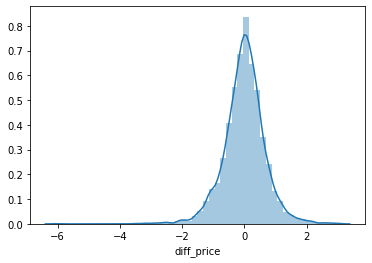

In [50]:
sns.distplot(df_fx["diff_price"])

In [51]:
df_fx.drop(["datetime", "time"], axis=1, inplace=True)
df_fx = df_fx[["date","diff_price","Open"]]
df_fx.head()

,date,diff_price,Open
613,20010103,-0.28,114.60
2006,20010104,2.08,114.32
3405,20010105,-0.09,116.40
4653,20010108,-0.50,116.31
6059,20010109,0.54,115.81


In [52]:
df_fx["date"] = pd.to_datetime(df_fx['date'].astype(str), format='%Y-%m-%d')
df_fx.tail(1)

,date,diff_price,Open
6559742,2019-07-30,-0.02,108.57


In [53]:
df_fx_selected = df_fx[(df_fx["date"]<=end_date) & (df_fx["date"]>=start_date)]
df_fx_selected.tail()

,date,diff_price,Open
5974958,2017-12-22,-0.09,113.36
5976272,2017-12-26,-0.10,113.27
5977650,2017-12-27,-0.41,113.17
5979090,2017-12-28,-0.18,112.76
5980530,2017-12-29,-0.21,112.58


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


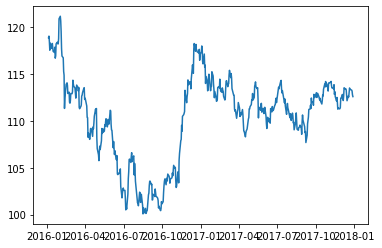

In [54]:
plt.plot(df_fx_selected["date"], df_fx_selected["Open"])

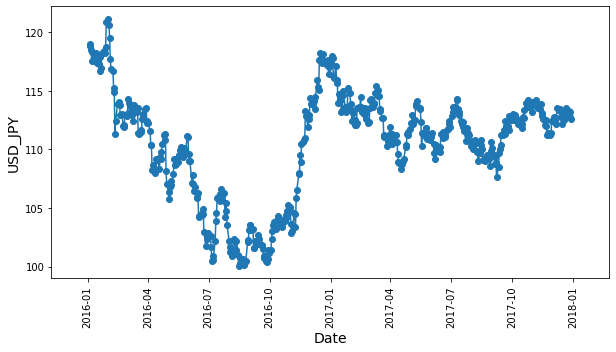

In [55]:
plt.figure(figsize=(10,5))
plt.scatter(df_fx_selected["date"],df_fx_selected["Open"])
plt.plot(df_fx_selected["date"],df_fx_selected["Open"])
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=14)
plt.ylabel('USD_JPY', fontsize=14)
plt.savefig('output/usdjpy_overall.png')

In [56]:
if surprise_level == 0:
    df_fx_selected["scaled_price"] = scale(df_fx_selected["diff_price"])
    df_fx_selected["sign"] = np.sign(df_fx_selected['diff_price'])
    print (df_fx_selected["sign"].unique())
    df_fx_selected["sign"] = np.where(df_fx_selected["sign"] == -1,2,df_fx_selected["sign"])
    print (df_fx_selected["sign"].unique())
elif surprise_level == 5:
    df_fx_selected["sign"] = 0
    df_fx_selected.loc[df_fx_selected['diff_price'] > 0.1, 'sign'] = 1
    df_fx_selected.loc[df_fx_selected['diff_price'] > 0.6, 'sign'] = 2
    df_fx_selected.loc[df_fx_selected['diff_price'] < -0.1, 'sign'] = -1 #3
    df_fx_selected.loc[df_fx_selected['diff_price'] < -0.6, 'sign'] = -2 #4
    print (df_fx_selected["sign"].unique())

[ 1. -1.  0.]
[1. 2. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



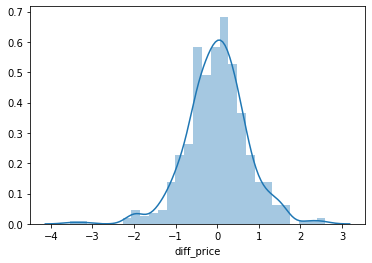

In [57]:
sns.distplot(df_fx_selected["diff_price"])

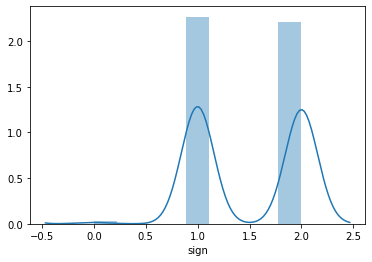

In [58]:
sns.distplot(df_fx_selected["sign"])

In [59]:
df_fx_selected.head(2)

,date,diff_price,Open,scaled_price,sign
5249548,2016-01-04,0.17,118.86,0.247883,1.0
5250988,2016-01-05,-0.58,119.03,-0.770654,2.0


# Combine FX and News data

In [60]:
df_fx_selected.dtypes

date            datetime64[ns]
diff_price             float64
Open                   float64
scaled_price           float64
sign                   float64
dtype: object

In [61]:
df_news.dtypes

date           datetime64[ns]
words                  object
category               object
c2id                    int64
word_length             int64
text                   object
bpe                    object
dtype: object

In [62]:
df_news["c2id"].unique()

array([0, 1, 2])

In [63]:
df_merge = pd.merge(df_fx_selected, df_news, on="date")
df_merge.head(2)

,date,diff_price,Open,scaled_price,sign,words,category,c2id,word_length,text,bpe
0,2016-01-04,0.17,118.86,0.247883,1.0,"[2307, 2031, 3117, 11278, 2761, 86, 2394, 5589...",IMPACT,2,14,ny governor andrew cuomo orders homeless shelt...,"[3281, 8153, 290, 1809, 18912, 17902, 6266, 10..."
1,2016-01-04,0.17,118.86,0.247883,1.0,"[5, 1480, 641, 1169, 642, 8852, 3469, 524, 206...",BUSINESS,0,14,us stocks fall chinese markets plummet losses ...,"[385, 14420, 2121, 442, 3762, 5939, 28940, 908..."


In [64]:
df_merge.tail(2)

,date,diff_price,Open,scaled_price,sign,words,category,c2id,word_length,text,bpe
2457,2017-12-29,-0.21,112.58,-0.268176,2.0,"[985, 267, 2751, 2009, 28, 1, 1120, 38, 637, 4...",CRIME,1,19,nypd officers suspended witnesses say nt check...,"[3281, 30094, 3790, 9951, 11432, 910, 299, 83,..."
2458,2017-12-29,-0.21,112.58,-0.268176,2.0,"[59, 1759, 350, 388, 3785, 1440, 345, 34, 93, ...",IMPACT,2,12,big environmental stories watch lawsuits focus...,"[14261, 6142, 3923, 2342, 17785, 5670, 4258, 1..."


In [65]:
df_merge["category"].unique()

array(['IMPACT', 'BUSINESS', 'CRIME'], dtype=object)

In [66]:
pd.set_option('display.max_colwidth', -1)
df_merge[["date","sign","text"]].head(20)

,date,sign,text
0,2016-01-04,1.0,ny governor andrew cuomo orders homeless shelters temperatures drop executive order takes effect tuesday
1,2016-01-04,1.0,us stocks fall chinese markets plummet losses china bad enough close stock markets day
2,2016-01-04,1.0,new year eve prank leaves glued mcdonald toilet kaya said painfully peeled seat running mom tears
3,2016-01-04,1.0,world elusive fugitive lam years john patrick hannan escaped prison england december
4,2016-01-04,1.0,gm working lyft build army selfdriving cars auto giant invested million uber main us rival
5,2016-01-05,2.0,atlanta motel standoff ends suspect stabbing decatur ga ap standoff motel outside atlanta involved number children ended tuesday morning
6,2016-01-05,2.0,us car sales set annual record us car sales hit annual record clearing previous peak reached lower gas prices interest rates spurred
7,2016-01-05,2.0,yet another reason love legos toy blocks outshining gold
8,2016-01-05,2.0,coal miner union wins big victory retired members still getting half money supposed
9,2016-01-05,2.0,ny homeless need housing services nt forced shelters advocates many experts oppose gov cuomo order usher homeless people shelters


In [67]:
if calculation_mode == "surprise":
    df_merge = df_merge[["date", "sign", "words","Open","bpe"]]
elif calculation_mode == "category":
    df_merge = df_merge[["date", "c2id", "words","bpe","text"]]
    df_merge["sign"] = df_merge["c2id"]
df_merge.head(1)

,date,sign,words,Open,bpe
0,2016-01-04,1.0,"[2307, 2031, 3117, 11278, 2761, 86, 2394, 5589, 1632, 327, 470, 403, 1282, 948]",118.86,"[3281, 8153, 290, 1809, 18912, 17902, 6266, 10463, 23629, 10101, 4268, 4640, 1502, 2753, 1245, 256, 3322]"


In [68]:
df_merge.dtypes

date     datetime64[ns]
sign     float64       
words    object        
Open     float64       
bpe      object        
dtype: object

In [69]:
df_merge.to_csv("data/merge_data.csv")

In [70]:
# df_merge["c2id"].unique()

## split dataset

In [89]:
# split data 
if encoding_mode == "tokenize":
#     x_train, x_test, y_train, y_test = train_test_split(
#         df_merge["words"].values, df_merge["sign"].values, test_size=0.33, random_state=42, shuffle=False)
    x_train, x_test0, y_train, y_test0 = train_test_split(
        df_merge["words"].apply(eval).values, df_merge["sign"].values, test_size=0.30, random_state=42, shuffle=False)
    x_validate, x_test, y_validate, y_test = train_test_split(
        x_test0,  y_test0, test_size=0.50, random_state=42, shuffle=False)
elif encoding_mode == "bpe":
#     x_train, x_test, y_train, y_test = train_test_split(
#         df_merge["bpe"].values, df_merge["sign"].values, test_size=0.33, random_state=42, shuffle=False)    
    
    encode_data = df_merge["bpe"].values#apply(eval).values
    x_train, x_test0, y_train, y_test0 = train_test_split(
        encode_data, df_merge["sign"].values, test_size=0.33, random_state=42, shuffle=False)  
    x_validate, x_test, y_validate, y_test = train_test_split(
        x_test0,  y_test0, test_size=0.50, random_state=42, shuffle=False)

In [90]:
# print (x_train)
# print (y_train)

In [91]:
print (type(x_train), type(y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [92]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=pad_maxlen)
x_validate = sequence.pad_sequences(x_validate, maxlen=pad_maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=pad_maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
# print (x_train)
# print (y_train)

Pad sequences (samples x time)
x_train shape: (1647, 50)
x_test shape: (406, 50)


In [95]:
from sklearn.preprocessing import LabelEncoder

# Encode text to labels
le = LabelEncoder()
le.fit(y_train)
train_labels_enc = le.transform(y_train)
validation_labels_enc = le.transform(y_validate)
test_labels_enc = le.transform(y_test)

print (y_train[0:4], train_labels_enc[0:4])
print (train_labels_enc.shape, test_labels_enc.shape)

[1. 1. 1. 1.] [1 1 1 1]
(1647,) (406,)


In [110]:
from keras.utils import to_categorical
# Convert a vector label to matrix label
y_train_ohe = to_categorical(train_labels_enc)
y_validate_ohe = to_categorical(validation_labels_enc)
y_test_ohe = to_categorical(test_labels_enc)
print (y_train_ohe.shape,y_test_ohe.shape[0])

(1647, 3) 406


## Run model

In [111]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

max_features = 20000
batch_size = 32

In [112]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y_train_ohe.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 2,691,971
Trainable params: 2,691,971
Non-trainable params: 0
_________________________________________________________________


In [113]:
print (x_train.shape, x_test.shape)
print (y_train_ohe.shape, y_test_ohe.shape)

(1647, 50) (406, 50)
(1647, 3) (406, 3)


In [115]:
print('Train...')
model_history = model.fit(x_train, y_train_ohe,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_validate, y_validate_ohe))
score, acc = model.evaluate(x_validate, y_validate_ohe,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 1647 samples, validate on 406 samples
Epoch 1/10
1647/1647 [==============================] - 3s 2ms/step - loss: 0.7997 - accuracy: 0.4876 - val_loss: 0.7388 - val_accuracy: 0.4310
Epoch 2/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.7286 - accuracy: 0.4918 - val_loss: 0.7314 - val_accuracy: 0.5690
Epoch 3/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.7263 - accuracy: 0.5404 - val_loss: 0.7343 - val_accuracy: 0.4310
Epoch 4/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.7092 - accuracy: 0.5707 - val_loss: 0.7314 - val_accuracy: 0.5567
Epoch 5/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.5116 - accuracy: 0.7808 - val_loss: 0.9113 - val_accuracy: 0.5542
Epoch 6/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.3227 - accuracy: 0.8707 - val_loss: 1.2199 - val_accuracy: 0.5000
Epoch 7/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.16

## plot accuracy

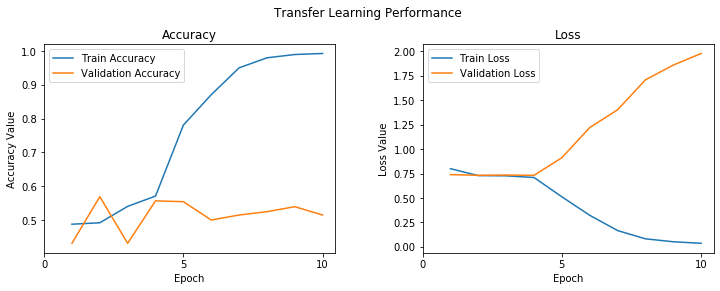

In [116]:
def plot_accuracy(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('Transfer Learning Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_lenght = len(history.history['accuracy'])+1
    epoch_list = list(range(1,epoch_lenght))
    
    # Plot accuracy
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epoch_lenght, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    # Plot loss
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epoch_lenght, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
plot_accuracy(model_history)

In [117]:
test_model = model.predict_classes(x_train)
print (set(y_train), set(test_model))

{0.0, 1.0, 2.0} {1, 2}


Accuracy: 0.9939283545840923
Precision: 0.9879062894100262
Recall: 0.9939283545840923
F1 Score: 0.990904983992427


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


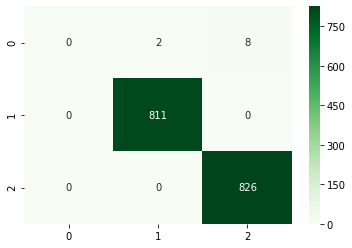

In [118]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def predict_model_confusion_matrix(x_train, y_train, model):
    predicted_labels = model.predict_classes(x_train)

    true_labels = y_train
    # get_metrics
    print('Accuracy:', metrics.accuracy_score(true_labels, predicted_labels))
    print('Precision:', metrics.precision_score(true_labels, predicted_labels, average='weighted'))
    print('Recall:', metrics.recall_score(true_labels, predicted_labels, average='weighted'))
    print('F1 Score:', metrics.f1_score(true_labels, predicted_labels,average='weighted'))

    # confusion matrix
    labels = list(set(y_train))
    cm = confusion_matrix(y_train, predicted_labels, labels=labels)
    cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
    sns.heatmap(cm_labeled, annot=True, cmap='Greens', fmt='g')
    return
predict_model_confusion_matrix(x_train, np.argmax(y_train_ohe,1), model)

Accuracy: 0.5147783251231527
Precision: 0.5259129445742022
Recall: 0.5147783251231527
F1 Score: 0.5141194745436208


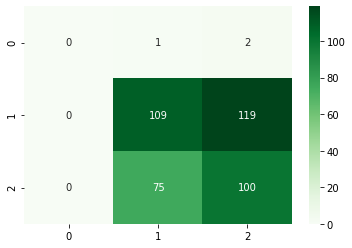

In [119]:
predict_model_confusion_matrix(x_validate, np.argmax(y_validate_ohe,1), model)

Accuracy: 0.49507389162561577
Precision: 0.4964072689505984
Recall: 0.49507389162561577
F1 Score: 0.49537729780284295


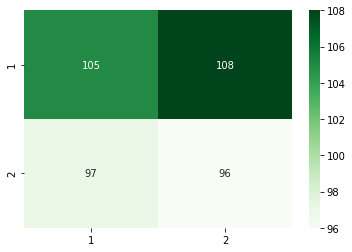

In [120]:
predict_model_confusion_matrix(x_test, np.argmax(y_test_ohe,1), model)

## visualise data using shap

In [106]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test[:10])

# init the JS visualization code
shap.initjs()

# transform the indexes to words
words = word_index
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])

# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[0])